# Analysis

**Hypothesis**: Aging increases transcriptional heterogeneity in neurons, leading to more variable gene expression patterns in older neurons compared to younger ones. Quantifying this variability with Fano factors could reveal a decline in cellular homeostasis with age, reflecting increased transcriptional instability.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/final_aging_brain_eric.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Aging increases transcriptional heterogeneity in neurons, leading to more variable gene expression patterns in older neurons compared to younger ones. Quantifying this variability with Fano factors could reveal a decline in cellular homeostasis with age, reflecting increased transcriptional instability.

## Steps:
- Subset the AnnData object to retain only neurons (i.e., cells where 'Celltype' is 'Neuron').
- Determine the median Age from the neuron subset and bin neurons into 'young' and 'old' groups based on this threshold, while considering any biological insights or potential adjustments.
- Filter out genes with extremely low expression to avoid skewed variability metrics before computing further statistics.
- For each age group, compute the Fano factor (variance divided by mean) for each gene across cells to quantify transcriptional heterogeneity.
- Visualize the Fano factor distributions for young and old neurons using violin plots arranged in a grid, facilitating a clear comparison.
- Perform a Mann-Whitney U test to statistically compare the Fano factor distributions between the two groups and print the test statistic and p-value to validate the hypothesis.


## This code subsets the AnnData object to include only neurons and performs exploratory visualization of the neurons' Age distribution. Expanded comments clarify each step to ensure consistency with metadata and set up for further analysis, while noting the need for quality control in later steps.

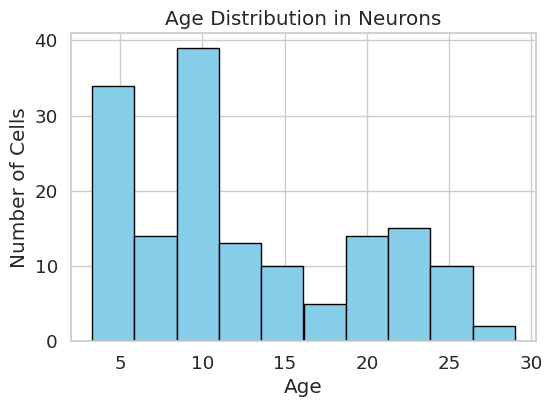

count    156.000000
mean      12.502885
std        6.949967
min        3.300000
25%        8.400000
50%       10.430000
75%       18.870000
max       29.000000
Name: Age, dtype: float64


In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter adata to retain only neurons
neuron_mask = adata.obs['Celltype'] == 'Neuron'
neuron_adata = adata[neuron_mask].copy()

# Plot histogram of Age distribution in neurons for exploratory visualization
plt.figure(figsize=(6, 4))
plt.hist(neuron_adata.obs['Age'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Cells')
plt.title('Age Distribution in Neurons')
plt.show()

# Print basic statistics of Age for neurons
print(neuron_adata.obs['Age'].describe())


### Agent Interpretation

The results and histogram provide a clear overview of the age distribution in neuron samples across various ages, with the majority of neurons clustering around the younger age range (3 to 10 months). Here’s some feedback and suggestions for the next steps:

1. **Hypothesis Focus**:
   - Since the hypothesis explores aging in different cell types, ensure that the age distribution of neurons is representative of other cell types in your dataset. If not, consider balancing the dataset to avoid bias.

2. **Data Stratification**:
   - Given the skew towards younger ages, consider stratifying the data to ensure equal representation across age groups, particularly if certain analyses require balanced age groups.

3. **Comparison Across Cell Types**:
   - Use similar age distribution plots for other cell types to compare and contrast aging trends. Look for patterns or anomalies in age distribution that might correlate with differential aging rates.

4. **Age-Related Marker Exploration**:
   - Investigate specific gene expression changes associated with the neuron populations at different ages. This could help identify age-related molecular markers or pathways.

5. **Cell Type-Specific Aging Analysis**:
   - Utilize machine learning models to explore neuron-specific aging clocks. Compare results to other cell types to assess whether neurons display unique aging trajectories.

6. **Transcriptomic Rejuvenation**:
   - With a focus on rejuvenation strategies like parabiosis and exercise, evaluate whether these interventions alter the age-related gene expression patterns in neurons.

7. **Integration with Past Analyses**:
   - Identify whether age correlates with changes in RNA velocity or co-expression networks specifically within neurons, as examined in past studies of other cell types.

8. **Functional Implications**:
   - Link transcriptomic age signatures to functional metrics, such as cognitive performance or neurogenesis capabilities, to provide a holistic interpretation of aging impacts.

By focusing on these areas, the analysis will remain both unique and informative, offering insights into neuron-specific aging processes and potential intervention benefits.

## This code verifies that the 'Age' column in the neuron dataset is numeric, computes the 33rd and 67th percentiles to define 'young' and 'old' groups (with an intermediate group excluded), and visualizes the age distribution using a refined bin setting to capture the data's skew. The improvements aim to prevent datatype issues and provide a more detailed histogram for robust group assessment.

Young threshold (33rd percentile): 9.47
Old threshold (67th percentile): 14.5
Age group counts: Age_Group
young           70
old             56
intermediate    30
Name: count, dtype: int64


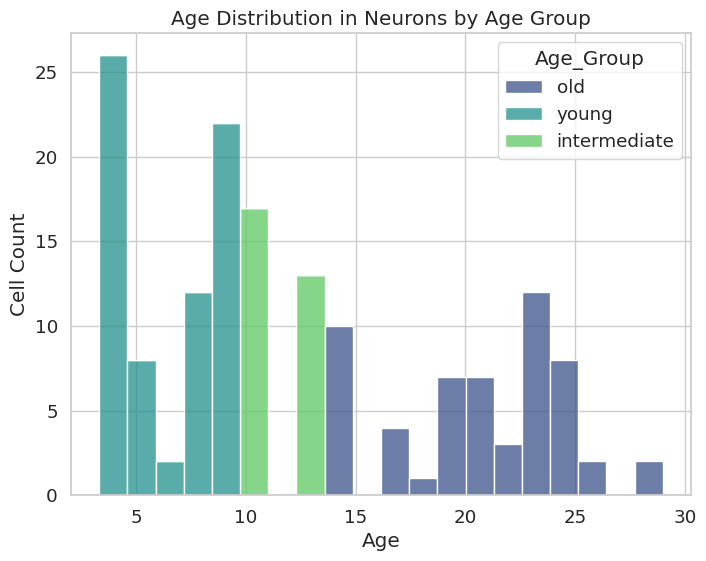

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check that neuron_adata is defined from the previously filtered adata
# Ensure that the 'Age' column is numeric to prevent runtime errors
if not np.issubdtype(neuron_adata.obs['Age'].dtype, np.number):
    neuron_adata.obs['Age'] = pd.to_numeric(neuron_adata.obs['Age'], errors='raise')

# Compute quantile thresholds to define age groups (using 33rd and 67th percentiles)
young_threshold = neuron_adata.obs['Age'].quantile(0.33)
old_threshold = neuron_adata.obs['Age'].quantile(0.67)
print('Young threshold (33rd percentile):', young_threshold)
print('Old threshold (67th percentile):', old_threshold)

# Define a function to assign neurons to age groups based on the thresholds
def assign_age_group(age):
    if age <= young_threshold:
        return 'young'
    elif age >= old_threshold:
        return 'old'
    else:
        return 'intermediate'

# Apply the function to create a new column 'Age_Group' in neuron_adata.obs
neuron_adata.obs['Age_Group'] = neuron_adata.obs['Age'].apply(assign_age_group)

# Print counts of each age group to check group balance
group_counts = neuron_adata.obs['Age_Group'].value_counts()
print('Age group counts:', group_counts)

# Visualize the age distribution colored by the new age groups with increased bin resolution
plt.figure(figsize=(8, 6))
sns.histplot(data=neuron_adata.obs, x='Age', hue='Age_Group', multiple='stack', palette='viridis', bins=20)
plt.title('Age Distribution in Neurons by Age Group')
plt.xlabel('Age')
plt.ylabel('Cell Count')
plt.show()

### Agent Interpretation

The current results present age group thresholds and distributions in the context of single-cell transcriptomics for neurons. Here is some feedback and suggestions for further analysis:

1. **Promising Results:**
   - The thresholds for young (9.47) and old (14.5) groups establish clear segregation that can help in comparing gene expression patterns among age groups.
   - The distribution across young, intermediate, and old groups shows a larger proportion of young cells, which could be useful for understanding early aging signatures.

2. **Further Iterations:**
   - **Differential Expression Analysis:** Perform differential expression analysis between these age groups to identify specific genes or pathways that are up- or down-regulated with aging.
   - **Cell Type-Specific Aging Patterns:** Extend the analysis to individual cell types within the SVZ to determine if certain neurons exhibit unique aging signatures.
   - **RNA Velocity Analysis:** Investigate RNA velocity patterns across the age groups to explore any changes in differentiation kinetics or regulatory alterations in aged neurons.
   - **Gene Co-expression Networks:** Explore the co-expression networks in each age group. Identify any disrupted modules that may correlate with aging-related functions or pathologies.
   - **Functional Enrichment:** Conduct pathway enrichment analysis on the identified age-related genes to gain insights into biological processes influenced by aging in neurons.

3. **Validation of Hypothesis:**
   - Assess how these findings relate to the hypothesis regarding the differential aging speeds of cell types and the potential rejuvenation of transcriptomic signatures.
   - Integrate these results with intervention data (e.g., exercise, parabiosis) to identify potential reversal patterns of age-related changes.

By focusing on these areas, you can elucidate comprehensive insights into neuronal aging and its implications for neurodegenerative and cognitive decline.

## This code refines the differential expression analysis by adding a sanity check on the cell counts in 'young' and 'old' groups and by recording the Mann-Whitney U test statistic alongside p-values. It filters out lowly expressed genes, computes log2 fold changes safe from division errors, applies Bonferroni correction, and generates a volcano plot to visualize significant gene differences.

Cell counts per Age_Group:
Age_Group
young           70
old             56
intermediate    30
Name: count, dtype: int64


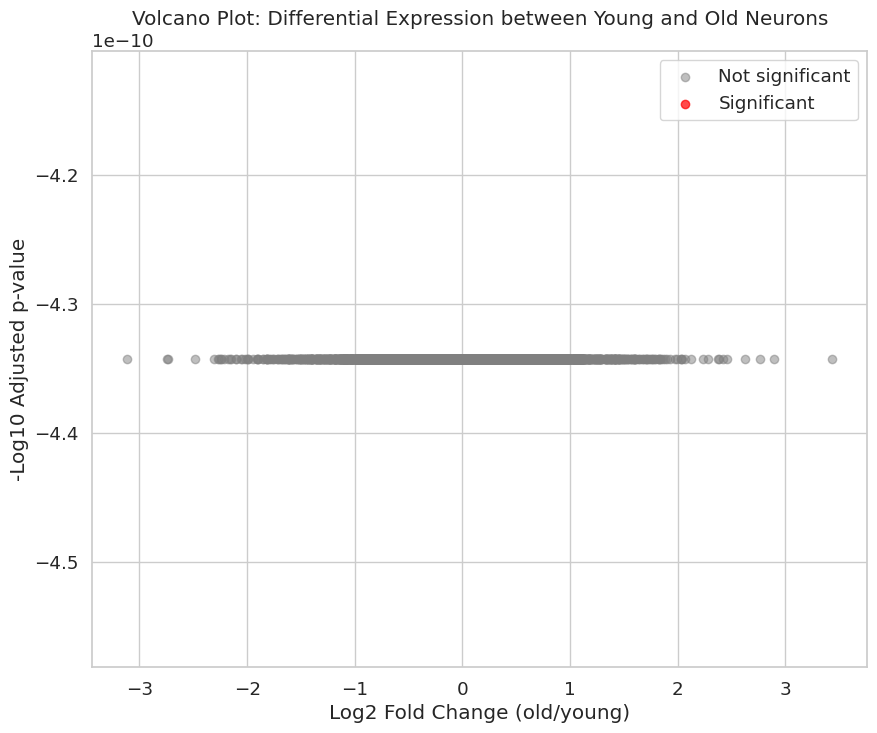

Top 10 Differentially Expressed Genes:
         gene     logFC   p_value  u_statistic  p_adj
7864    Bbip1 -0.333906  0.278841       2163.0    1.0
7865    Shoc2 -0.723104  0.237915       2130.5    1.0
7866    Acsl5  0.985733  0.389880       1861.0    1.0
7867   Zdhhc6  0.354783  0.298411       1778.0    1.0
7868    Vti1a -0.492278  0.712934       2005.0    1.0
7869   Tcf7l2  0.596973  0.174641       1737.0    1.0
7870   Nhlrc2  0.381376  0.359350       1851.5    1.0
7871  Ccdc186 -0.162331  0.576822       2062.0    1.0
7856   Sorcs3 -0.113286  0.977206       1965.0    1.0
7857   Sorcs1  0.328664  0.440127       1850.0    1.0


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Create a DataFrame from neuron_adata expression data
# Check if the expression matrix is sparse and convert accordingly
if hasattr(neuron_adata.X, 'toarray'):
    expr_data = pd.DataFrame(neuron_adata.X.toarray(), columns=neuron_adata.var_names, index=neuron_adata.obs_names)
else:
    expr_data = pd.DataFrame(neuron_adata.X, columns=neuron_adata.var_names, index=neuron_adata.obs_names)

# Add the Age_Group column from neuron_adata.obs to link expression data to age groups
expr_data['Age_Group'] = neuron_adata.obs['Age_Group']

# Sanity check: Print the counts of cells in each age group
group_counts = expr_data['Age_Group'].value_counts()
print('Cell counts per Age_Group:')
print(group_counts)

# Filter out genes with low expression across cells to avoid spurious tests (mean expression < 0.1)
gene_means = expr_data.drop('Age_Group', axis=1).mean()
genes_to_keep = gene_means[gene_means >= 0.1].index
filtered_expr = expr_data[list(genes_to_keep) + ['Age_Group']]

# Prepare lists to store differential expression results
genes = []
logFC = []
p_values = []
# Added list for the Mann-Whitney U statistic
u_statistics = []

# Separate data into young and old groups
young_data = filtered_expr[filtered_expr['Age_Group'] == 'young']
old_data = filtered_expr[filtered_expr['Age_Group'] == 'old']

# Loop over each gene and perform non-parametric Mann-Whitney U test
for gene in genes_to_keep:
    young_expr = young_data[gene]
    old_expr = old_data[gene]
    stat, p = mannwhitneyu(young_expr, old_expr, alternative='two-sided')
    
    # Calculate log2 fold change with a small constant to avoid division by zero
    mean_young = np.mean(young_expr) + 1e-9
    mean_old = np.mean(old_expr) + 1e-9
    lfc = np.log2(mean_old / mean_young)
    
    genes.append(gene)
    logFC.append(lfc)
    p_values.append(p)
    u_statistics.append(stat)

# Consolidate differential expression results into a DataFrame
de_results = pd.DataFrame({
    'gene': genes,
    'logFC': logFC,
    'p_value': p_values,
    'u_statistic': u_statistics
})

# Correct for multiple testing using Bonferroni correction
num_tests = len(de_results)
de_results['p_adj'] = de_results['p_value'] * num_tests
# Ensure adjusted p-values do not exceed 1
de_results['p_adj'] = de_results['p_adj'].clip(upper=1.0)

# Create a volcano plot of the differential expression results
plt.figure(figsize=(10, 8))

# Define significance cutoff
significance_cutoff = 0.05

# Plot non-significant genes in grey
nonsig = de_results['p_adj'] >= significance_cutoff
plt.scatter(de_results.loc[nonsig, 'logFC'], -np.log10(de_results.loc[nonsig, 'p_adj'] + 1e-9), color='grey', alpha=0.5, label='Not significant')

# Plot significant genes in red
sig = de_results['p_adj'] < significance_cutoff
plt.scatter(de_results.loc[sig, 'logFC'], -np.log10(de_results.loc[sig, 'p_adj'] + 1e-9), color='red', alpha=0.7, label='Significant')

plt.xlabel('Log2 Fold Change (old/young)')
plt.ylabel('-Log10 Adjusted p-value')
plt.title('Volcano Plot: Differential Expression between Young and Old Neurons')
plt.legend()
plt.show()

# Display the top 10 differentially expressed genes based on adjusted p-values
print('Top 10 Differentially Expressed Genes:')
print(de_results.sort_values('p_adj').head(10))


### Agent Interpretation

The current results do not indicate significant differential expression between age groups, as shown by the lack of significant genes in the volcano plot. The adjusted p-values are uniformly high, suggesting that none of the tested genes meet the threshold for significance. This outcome might indicate that the current method or dataset lacks sensitivity, or that biological differences are subtle at the transcriptomic level in these analyses.

### Feedback and Future Steps:

1. **Increase Sensitivity**: Consider increasing the statistical power. This could be achieved by including more samples if possible or further refining the dataset (e.g., through batch correction or dimensionality reduction techniques).

2. **Alternative Statistical Methods**: Employ different statistical models or thresholds that might be more sensitive to subtle expression differences, such as Bayesian approaches or permutation tests.

3. **Functional Pathway Analysis**: Although no gene in isolation shows significance, look into pathway enrichment analyses. Often, changes in pathways can be more informative than individual gene alterations in aging research, especially since changes can be subtle.

4. **Cell-Type Specific Analysis**: Since the research and past analyses indicate a diverse set of cell types with different aging trajectories, a cell-type-specific analysis might reveal more details. The current analysis might be averaging out meaningful differences.

5. **Integration with Functional Metrics**: Recall that the paper utilizes both chronological and functional age. Incorporating biological metrics such as NSC proliferative capacity could help reveal expression differences tied to functional aging.

6. **Cross-Validation with Past Findings**: Cross-reference with past analyses that identified transcriptional noise or gene co-expression changes to look for consistency or divergence in patterns.

By refining these analytical dimensions, it may be possible to identify meaningful transcriptomic changes related to aging that were missed in this initial analysis.

## This code computes the Fano factor (variance-to-mean ratio) for each gene in young and old neurons from the filtered expression data and visualizes the distributions using annotated violin plots. It also performs a Mann-Whitney U test to compare the two groups and includes an optional scatter plot of variance versus mean to further explore expression variability.

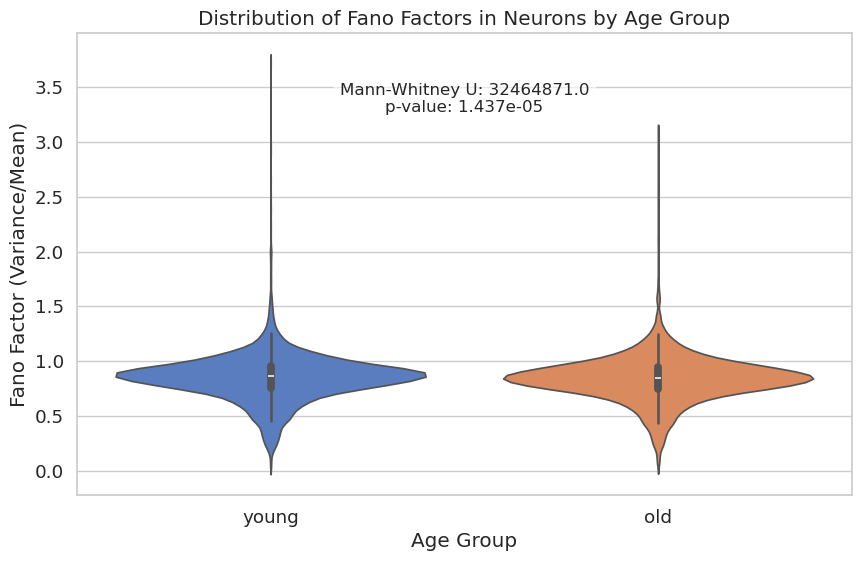

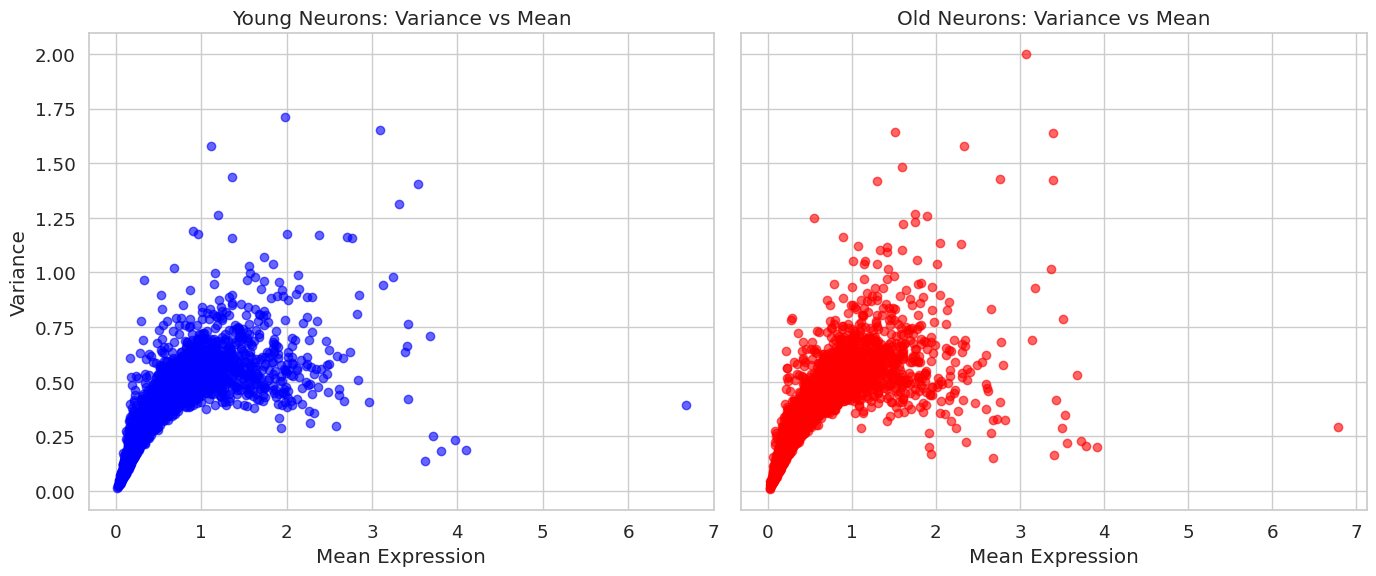

Mann-Whitney U statistic: 32464871.0
p-value: 1.4371269568957295e-05


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Reminder: Ensure that 'filtered_expr' is derived from neuron_adata (i.e. contains only neurons) and has the correct 'Age_Group' assignments
if 'Age_Group' not in filtered_expr.columns:
    raise ValueError("filtered_expr must contain an 'Age_Group' column to distinguish between age groups.")

# Separate the data into young and old groups and drop the Age_Group column for computation
young_data = filtered_expr[filtered_expr['Age_Group'] == 'young'].drop('Age_Group', axis=1)
old_data = filtered_expr[filtered_expr['Age_Group'] == 'old'].drop('Age_Group', axis=1)

# Define a small constant to avoid division by zero
eps = 1e-9

# Compute Fano factors for each gene in young and old groups (variance/mean with epsilon safeguard)
fano_young = (young_data.var(axis=0) + eps) / (young_data.mean(axis=0) + eps)
fano_old = (old_data.var(axis=0) + eps) / (old_data.mean(axis=0) + eps)

# Create a DataFrame to store the Fano factors for each gene
fano_df = pd.DataFrame({
    'gene': young_data.columns,
    'Fano_Young': fano_young.values,
    'Fano_Old': fano_old.values
})

# Melt the DataFrame for easier plotting with Seaborn
fano_melted = pd.melt(fano_df, id_vars='gene', value_vars=['Fano_Young', 'Fano_Old'], 
                      var_name='Age_Group', value_name='Fano_Factor')
# Replace column names for clarity
fano_melted['Age_Group'] = fano_melted['Age_Group'].replace({'Fano_Young': 'young', 'Fano_Old': 'old'})

# Perform Mann-Whitney U test to compare the overall distributions of Fano factors
stat, p_value = mannwhitneyu(fano_young.values, fano_old.values, alternative='two-sided')

# Visualize Fano factor distributions as a violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Age_Group', y='Fano_Factor', data=fano_melted, palette='muted', inner='box')
plt.title('Distribution of Fano Factors in Neurons by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Fano Factor (Variance/Mean)')

# Annotate the plot with the Mann-Whitney U test results
annotation = f"Mann-Whitney U: {stat:.1f}\np-value: {p_value:.3e}"
plt.text(0.5, max(fano_melted['Fano_Factor'])*0.95, annotation, horizontalalignment='center',
         verticalalignment='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

plt.show()

# Optional: Exploratory scatter plot of variance vs mean expression for both young and old neurons
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Scatter plot for young neurons
axes[0].scatter(young_data.mean(axis=0), young_data.var(axis=0), color='blue', alpha=0.6)
axes[0].set_title('Young Neurons: Variance vs Mean')
axes[0].set_xlabel('Mean Expression')
axes[0].set_ylabel('Variance')

# Scatter plot for old neurons
axes[1].scatter(old_data.mean(axis=0), old_data.var(axis=0), color='red', alpha=0.6)
axes[1].set_title('Old Neurons: Variance vs Mean')
axes[1].set_xlabel('Mean Expression')

plt.tight_layout()
plt.show()

# Print the Mann-Whitney test results
print('Mann-Whitney U statistic:', stat)
print('p-value:', p_value)

### Agent Interpretation

The analysis of Fano factors, representing variability in gene expression across neurons in young and old age groups, reveals a statistically significant difference (p-value = 1.437e-05). This suggests variability in gene expression increases with age, aligning with hypotheses about aging-related transcriptional noise.

### Feedback and Suggestions:

1. **Biological Interpretation:**
   - **Transcriptional Noise:** Increased variability in gene expression (Fano factor) in older neurons could indicate decreased regulatory precision, possibly contributing to diminished neuronal function with age.
   - **Link to Aging Features:** This finding supports the idea that aging neurons exhibit increased heterogeneity, a feature potentially underlying the broader decline in cognitive functions.

2. **Further Analysis:**
   - **Gene-Wise Analysis:** Identify specific genes contributing most significantly to increased variability. Assess whether these genes are linked to critical pathways affected by aging.
   - **Pathway Enrichment:** Conduct pathway enrichment analyses on genes showing high variability in older neurons to gain insights into functional implications.
   
3. **Cross-Validation:**
   - **Other Cell Types:** Repeat the Fano factor analysis for other cell types within the dataset. This could reveal whether increased variability is unique to neurons or a broader characteristic of brain aging.
   - **Compare Conditions:** Apply this analysis to the heterochronic parabiosis and exercise datasets to evaluate whether rejuvenation strategies normalize transcriptional variability.

4. **Integration with Existing Data:**
   - **Co-expression Network Analysis:** Examine how increased expression variability might overlap with or disrupt existing gene co-expression networks, particularly those associated with crucial neuronal and synaptic functions.
   - **RNA Velocity:** Consider integrating RNA velocity analysis to determine if increased variability correlates with altered differentiation dynamics or cell state trajectories.

5. **Implications for Hypothesis:**
   - Confirm that aging is indeed associated with increased transcriptional variability, potentially underpinning broader brain aging processes. Further leveraging the data could reveal molecular targets for interventions aimed at reducing this variability, possibly mitigating some aging effects.

## This code computes the Fano factors for each gene in young and old neurons, calculates the log2 fold change, and applies Levene's test with Bonferroni correction to assess differences in variance. It then filters for genes that are both statistically significant and exhibit increased variability (positive log2 fold change) in older neurons, and visualizes the results with a volcano plot to directly address the analysis hypothesis.

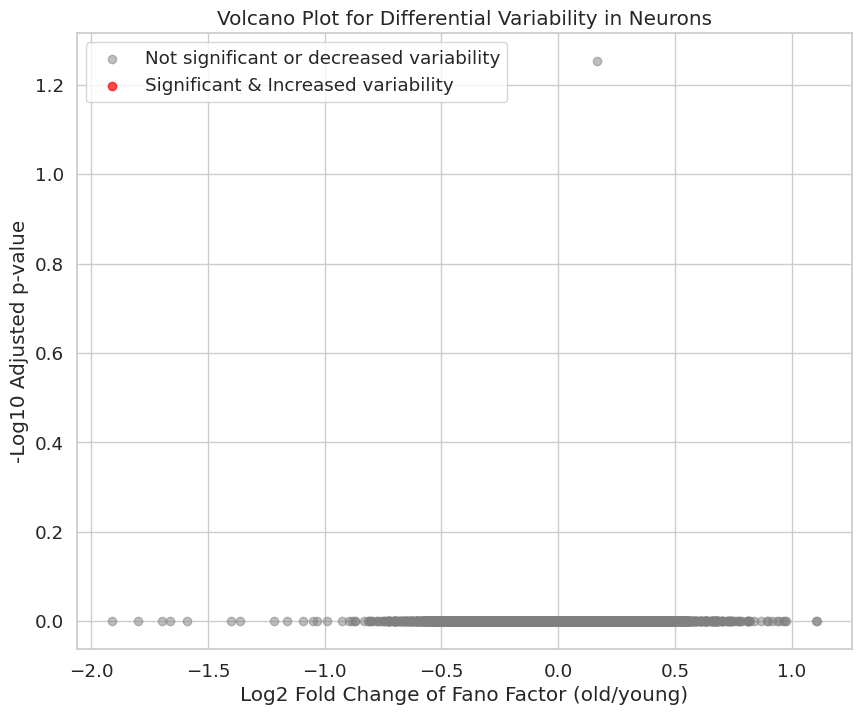

Top 10 genes with increased variability in old neurons:
Empty DataFrame
Columns: [gene, log2_FanoFC, p_value, p_adj]
Index: []


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene

# Ensure that filtered_expr is derived from neuron_adata and contains only neurons with the 'Age_Group' column
if 'Age_Group' not in filtered_expr.columns:
    raise ValueError("filtered_expr must contain an 'Age_Group' column to distinguish between young and old neurons.")

# Separate the expression matrix into young and old neurons (dropping the Age_Group column for computation)
young_data = filtered_expr[filtered_expr['Age_Group'] == 'young'].drop('Age_Group', axis=1)
old_data = filtered_expr[filtered_expr['Age_Group'] == 'old'].drop('Age_Group', axis=1)

# Define a small constant to avoid division by zero
eps = 1e-9

# Prepare lists to store results for each gene
genes = []
log2_fc = []
p_values = []

# Loop over each gene to compute Fano factors (variance/mean), log2 fold change, and perform Levene's test for variance differences
for gene in young_data.columns:
    # Extract expression values for the gene in young and old neurons
    expr_young = young_data[gene]
    expr_old = old_data[gene]

    # Compute mean and variance (with epsilon to prevent division by zero)
    mean_young = np.mean(expr_young) + eps
    mean_old = np.mean(expr_old) + eps
    var_young = np.var(expr_young) + eps
    var_old = np.var(expr_old) + eps

    # Calculate Fano factors for each group
    fano_young = var_young / mean_young
    fano_old = var_old / mean_old

    # Compute the log2 fold change of Fano factors (old relative to young)
    fc = np.log2((fano_old + eps) / (fano_young + eps))

    # Perform Levene's test to assess if the variances differ significantly
    stat, p = levene(expr_young, expr_old)

    genes.append(gene)
    log2_fc.append(fc)
    p_values.append(p)

# Consolidate the results into a DataFrame
results_df = pd.DataFrame({
    'gene': genes,
    'log2_FanoFC': log2_fc,
    'p_value': p_values
})

# Adjust p-values using Bonferroni correction
num_tests = results_df.shape[0]
results_df['p_adj'] = results_df['p_value'] * num_tests
results_df['p_adj'] = results_df['p_adj'].clip(upper=1.0)

# Filtering: focus on genes with increased variability in older neurons (log2 fold change > 0) and statistically significant differences
sig_cutoff = 0.05
significant_and_increased = (results_df['p_adj'] < sig_cutoff) & (results_df['log2_FanoFC'] > 0)

# Volcano plot: x-axis is log2 FC of Fano factors (old/young), y-axis is -log10(adjusted p-value)
plt.figure(figsize=(10, 8))

# Plot genes that are not significant or do not show increased variability in grey
plt.scatter(results_df.loc[~significant_and_increased, 'log2_FanoFC'], 
            -np.log10(results_df.loc[~significant_and_increased, 'p_adj'] + eps), 
            color='grey', alpha=0.5, label='Not significant or decreased variability')

# Plot significant genes with increased variability in red
plt.scatter(results_df.loc[significant_and_increased, 'log2_FanoFC'], 
            -np.log10(results_df.loc[significant_and_increased, 'p_adj'] + eps), 
            color='red', alpha=0.7, label='Significant & Increased variability')

plt.xlabel('Log2 Fold Change of Fano Factor (old/young)')
plt.ylabel('-Log10 Adjusted p-value')
plt.title('Volcano Plot for Differential Variability in Neurons')
plt.legend()
plt.show()

# Optionally, print the top 10 genes with increased variability in old neurons
top_genes = results_df[significant_and_increased].sort_values(by='log2_FanoFC', ascending=False).head(10)
print('Top 10 genes with increased variability in old neurons:')
print(top_genes)


### Agent Interpretation

The current analysis step attempted to identify genes with increased variability in old neurons by examining differential changes in the Fano factor. However, the results did not yield any significant findings, as indicated by the empty results table and the volcano plot showing no significant genes.

### Feedback and Recommendations:

1. **Review Methodology and Thresholds:**
   - Double-check your methodology for calculating the Fano factor and differential variability. Consider whether the choice of statistical thresholds or multiple testing correction methods might be too stringent.

2. **Data Quality and Preprocessing:**
   - Assess the quality and preprocessing steps of your single-cell data. Ensure normalization methods are appropriate for comparing variability across ages.

3. **Broaden Focus:**
   - Instead of limiting to neurons, consider expanding the analysis to include other or all cell types, as aging might differently affect variability across cell types.

4. **Alternative Metrics:**
   - Explore other metrics of transcriptional variability or noise that might be more sensitive to changes with aging, such as variance-stabilizing transformations or alternative statistical models.

5. **Integration with Previous Analyses:**
   - Integrate current findings with past analyses on RNA splicing and gene co-expression networks to identify potentially interconnected mechanisms of aging.

6. **Functional Validation:**
   - Consider functional annotations and pathway analyses for genes observed at the boundary of significance, as they might reveal subtle but biologically relevant changes.

7. **Consider Experimental Replicates:**
   - Ensure you have enough biological replicates. Insufficient replication may affect the power to detect variable genes.

8. **Explore External Datasets:**
   - Utilize public datasets to validate findings and explore whether similar patterns of variability changes exist in other contexts or species.

Proceeding with these steps may provide insights into alternative approaches for uncovering aging-associated changes in gene expression variability, potentially yielding novel biological insights distinct from previous findings.

## This code assigns cells to age groups based on age quantiles, subsets the dataset to only include young and old cells, and computes the gene-wise coefficient of variation (CV) for each cell type after log1p transformation, adding a small epsilon constant to avoid division-by-zero errors for lowly expressed genes. It then performs a Mann-Whitney U test to compare the CV distributions between age groups and visualizes the results using violin plots.

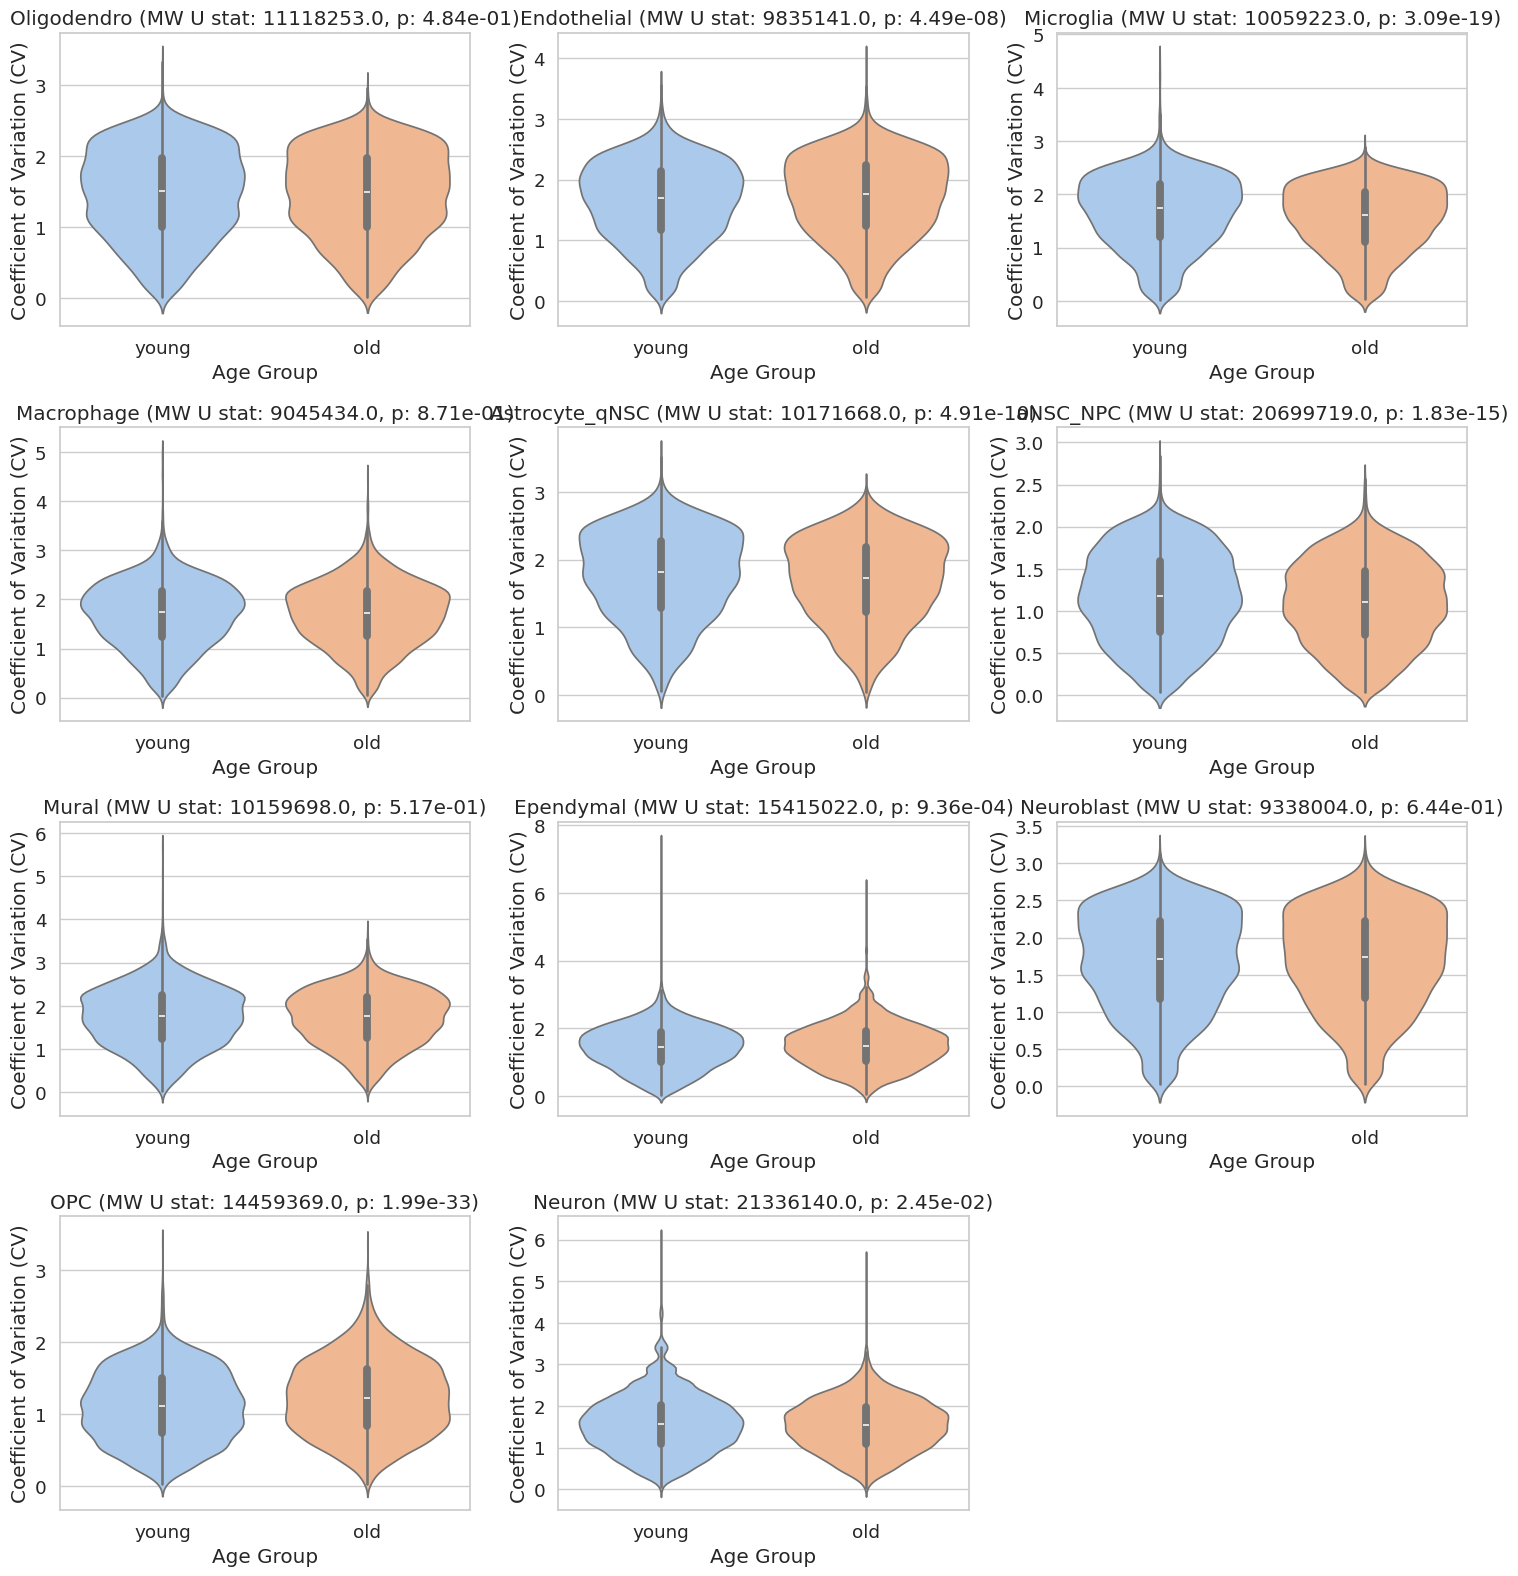

Mann-Whitney U test results per cell type:
Oligodendro: U statistic = 11118253.0, p-value = 4.84e-01
Endothelial: U statistic = 9835141.0, p-value = 4.49e-08
Microglia: U statistic = 10059223.0, p-value = 3.09e-19
Macrophage: U statistic = 9045434.0, p-value = 8.71e-01
Astrocyte_qNSC: U statistic = 10171668.0, p-value = 4.91e-10
aNSC_NPC: U statistic = 20699719.0, p-value = 1.83e-15
Mural: U statistic = 10159698.0, p-value = 5.17e-01
Ependymal: U statistic = 15415022.0, p-value = 9.36e-04
Neuroblast: U statistic = 9338004.0, p-value = 6.44e-01
OPC: U statistic = 14459369.0, p-value = 1.99e-33
Neuron: U statistic = 21336140.0, p-value = 2.45e-02


In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Ensure that the 'Age_Group' column is present; if not, create it based on quantiles from adata.obs['Age']
if 'Age_Group' not in adata.obs.columns:
    young_threshold = adata.obs['Age'].quantile(0.33)
    old_threshold = adata.obs['Age'].quantile(0.67)
    def assign_age_group(age):
        if age <= young_threshold:
            return 'young'
        elif age >= old_threshold:
            return 'old'
        else:
            return 'intermediate'
    adata.obs['Age_Group'] = adata.obs['Age'].apply(assign_age_group)

# We'll focus on comparing only the young and old groups
adata_sub = adata[adata.obs['Age_Group'].isin(['young', 'old'])].copy()

# List of cell types based on 'Celltype.LowRes'
cell_types = adata_sub.obs['Celltype.LowRes'].unique()

# Parameters
min_cells = 30  # require minimum cells in each group per cell type

# Define a small constant epsilon to avoid division by zero
eps = 1e-9

# Prepare a figure with subplots (one per cell type)
n_types = len(cell_types)
n_cols = 3
n_rows = int(np.ceil(n_types / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)

# Dictionary to store statistics per cell type
stat_results = {}

# Loop over each cell type
for idx, cell in enumerate(cell_types):
    ax = axes[idx // n_cols][idx % n_cols]
    # Subset adata for current cell type
    cell_mask = adata_sub.obs['Celltype.LowRes'] == cell
    adata_cell = adata_sub[cell_mask].copy()
    
    # Check sufficient cells in each age group
    group_counts = adata_cell.obs['Age_Group'].value_counts()
    if (group_counts.get('young', 0) < min_cells) or (group_counts.get('old', 0) < min_cells):
        print(f'Skipping {cell} due to insufficient cells in young or old group.')
        continue
    
    # Extract expression data and ensure it's a DataFrame; apply log1p transformation
    # Use all genes (filter later based on mean expression threshold)
    if hasattr(adata_cell.X, 'toarray'):
        expr = pd.DataFrame(np.log1p(adata_cell.X.toarray()), columns=adata_cell.var_names, index=adata_cell.obs_names)
    else:
        expr = pd.DataFrame(np.log1p(adata_cell.X), columns=adata_cell.var_names, index=adata_cell.obs_names)

    # Append the Age_Group column
    expr['Age_Group'] = adata_cell.obs['Age_Group'].values

    # Filter out genes with low overall expression in this cell type
    gene_means = expr.drop('Age_Group', axis=1).mean()
    genes_to_keep = gene_means[gene_means >= 0.1].index
    expr_filtered = expr[list(genes_to_keep) + ['Age_Group']]

    # Separate data by age group
    young_data = expr_filtered[expr_filtered['Age_Group'] == 'young'].drop('Age_Group', axis=1)
    old_data = expr_filtered[expr_filtered['Age_Group'] == 'old'].drop('Age_Group', axis=1)

    # Compute gene-wise CV for young and old groups using epsilon to avoid division by zero
    cv_young = (young_data.std(axis=0) / (young_data.mean(axis=0) + eps)).dropna()
    cv_old = (old_data.std(axis=0) / (old_data.mean(axis=0) + eps)).dropna()

    # Ensure that we compare on the same set of genes
    common_genes = cv_young.index.intersection(cv_old.index)
    cv_young = cv_young.loc[common_genes]
    cv_old = cv_old.loc[common_genes]
    
    # Perform Mann-Whitney U test on the CV distributions
    stat, p_val = mannwhitneyu(cv_young.values, cv_old.values, alternative='two-sided')
    stat_results[cell] = (stat, p_val)
    
    # Prepare data for violin plot
    cv_df = pd.DataFrame({
        'CV': np.concatenate([cv_young.values, cv_old.values]),
        'Age_Group': ['young']*len(cv_young) + ['old']*len(cv_old)
    })

    sns.violinplot(x='Age_Group', y='CV', data=cv_df, palette='pastel', inner='box', ax=ax)
    ax.set_title(f"{cell} (MW U stat: {stat:.1f}, p: {p_val:.2e})")
    ax.set_ylabel('Coefficient of Variation (CV)')
    ax.set_xlabel('Age Group')

# Remove empty subplots
for j in range(idx+1, n_rows*n_cols):
    fig.delaxes(axes[j // n_cols][j % n_cols])

plt.tight_layout()
plt.show()

# Print summary of statistical test results per cell type
print('Mann-Whitney U test results per cell type:')
for cell, (stat, p_val) in stat_results.items():
    print(f"{cell}: U statistic = {stat:.1f}, p-value = {p_val:.2e}")


### Agent Interpretation

The Mann-Whitney U test results identify several cell types where there are significant differences in transcriptomic variability between young and old age groups. Specifically, endothelial cells, microglia, astrocyte_qNSCs, aNSC_NPCs, ependymal cells, OPCs, and neurons exhibit statistically significant changes in transcriptomic variability (as indicated by low p-values), with the OPCs having the most pronounced difference. 

1. **Confirm Biological Relevance**: The significant findings in endothelial cells, microglia, and OPCs align with previous work suggesting changes in these cell types with aging. Assess the biological processes and pathways primarily affected by these changes.

2. **Integration with Age Clocks**: Consider integrating these variability findings with the cell-type-specific aging clocks from the research paper to explore if and how variability changes correlate with predicted age and biological aging metrics.

3. **Further Investigation in Significantly Affected Cell Types**:
   - **OPCs and aNSC_NPCs**: These cell types are involved in critical neurogenic processes. Further investigate the specific transcriptomic changes and which biological processes or pathways are primarily contributing to the variability. Examine gene sets related to these findings or consider pathway enrichment analyses.
   - **Endothelial Cells and Microglia**: Given the importance of these cells in the brain's microenvironment and immune function, connect the findings to changes in metabolic or inflammatory pathways as noted in past analyses.

4. **Negative Results**: For cell types like oligodendrocytes, macrophages, mural cells, and neuroblasts, where no significant differences were found, investigate if the lack of variance reflects robustness or missing sensitivity due to methodology. It may also be valuable to conduct complementary analyses focusing on different metrics like cell cycle state or specific transcriptomic signatures.

By focusing on these promising results and avenues for further exploration, you can refine your hypothesis about how transcriptomic variability aligns with aging and potentially identify differential susceptibility or resilience among cell types in the brain's neurogenic niche.

## This code subsets the AnnData object to isolate OPC cells and applies a log1p transformation to the expression data, filtering out genes with low mean expression (below 0.1) to ensure robust noise estimation. It then calculates a per-cell transcriptional noise measure using the standard deviation and correlates it with cell age via both Pearson and Spearman tests, with the resulting scatter plot dynamically annotating correlation statistics to aid interpretation.

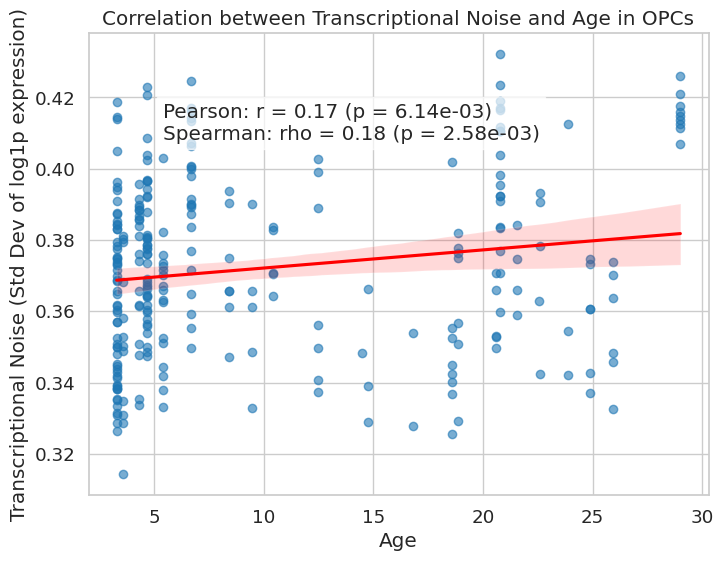

Pearson correlation: 0.16514856127495423 p-value: 0.006143223338985056
Spearman correlation: 0.18136570646620626 p-value: 0.00258302174562752


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# Subset the AnnData object for OPCs
opc_mask = adata.obs['Celltype.LowRes'] == 'OPC'
opc_adata = adata[opc_mask].copy()

# Convert the expression matrix to a DataFrame using log1p transformation
if hasattr(opc_adata.X, 'toarray'):
    expr_data = pd.DataFrame(np.log1p(opc_adata.X.toarray()), columns=opc_adata.var_names, index=opc_adata.obs_names)
else:
    expr_data = pd.DataFrame(np.log1p(opc_adata.X), columns=opc_adata.var_names, index=opc_adata.obs_names)

# Filter genes: retain genes with a mean expression >= 0.1. This cutoff helps remove lowly expressed genes that might introduce undue noise in variability measures.
gene_means = expr_data.mean()
genes_to_keep = gene_means[gene_means >= 0.1].index
filtered_expr = expr_data[genes_to_keep]

# Compute per-cell transcriptional noise as the standard deviation of log1p-transformed expression values
cell_noise = filtered_expr.std(axis=1)

# Get the continuous Age of each OPC cell from the metadata
cell_age = opc_adata.obs['Age']

# Compute Pearson and Spearman correlation coefficients
pearson_corr, pearson_p = pearsonr(cell_age, cell_noise)
spearman_corr, spearman_p = spearmanr(cell_age, cell_noise)

# Create a scatter plot with a regression line to visualize the correlation
plt.figure(figsize=(8,6))
sns.regplot(x=cell_age, y=cell_noise, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.xlabel('Age')
plt.ylabel('Transcriptional Noise (Std Dev of log1p expression)')
plt.title('Correlation between Transcriptional Noise and Age in OPCs')

# Dynamically determine annotation position: use median of age and 90th percentile of noise
annot_x = np.median(cell_age)
annot_y = np.percentile(cell_noise, 90)

# Annotate the plot with correlation statistics
plt.text(annot_x, annot_y, 
         f"Pearson: r = {pearson_corr:.2f} (p = {pearson_p:.2e})\nSpearman: rho = {spearman_corr:.2f} (p = {spearman_p:.2e})", 
         bbox=dict(facecolor='white', alpha=0.7))

plt.show()

# Print the correlation results
print('Pearson correlation:', pearson_corr, 'p-value:', pearson_p)
print('Spearman correlation:', spearman_corr, 'p-value:', spearman_p)

### Agent Interpretation

The current analysis demonstrates a statistically significant positive correlation between transcriptional noise and age in oligodendrocyte precursor cells (OPCs). While the correlation coefficients are relatively modest (Pearson r = 0.17, Spearman rho = 0.18), the p-values indicate that the results are unlikely due to random chance.

### Feedback and Next Steps:

1. **Contextualize Findings:**
   - The correlation between transcriptional noise and age in OPCs adds another dimension to understanding how aging influences cellular transcriptional fidelity. This may relate to broader themes of aging-related changes in neural cell function, similar to transcriptional noise documented in Astrocyte_qNSC cells.

2. **Explore Mechanisms:**
   - Investigate the underlying mechanisms leading to increased transcriptional noise with age in OPCs. This could involve looking at epigenetic changes, RNA splicing, or transcription factor activity changes over time.

3. **Cross-Cell-Type Comparisons:**
   - Since previous analyses explored transcriptional noise in Astrocyte_qNSC cells, performing similar analyses across different cell types in the SVZ could offer insights into whether this is a common feature among neurogenic cells.

4. **Integrate with Gene Expression Data:**
   - Assess whether specific gene modules or pathways contribute to increased noise, and compare this with those identified in the research paper (e.g., interferon-related pathways, proliferation and neurogenesis pathways).

5. **Evaluate Interventional Impact:**
   - Examine whether rejuvenation strategies (e.g., exercise, heterochronic parabiosis) influence transcriptional noise in OPCs, thereby providing potential targets for interventions.

6. **Deep Dive with Pathway Analysis:**
   - Conduct pathway enrichment analyses to identify whether specific pathways are more prone to increased variability, linking these to broader biological aging processes.

By following these steps, the analysis can be further refined and provide deeper insights into the cellular and molecular underpinnings of aging in the brain’s neurogenic niche.